
# Variational autoencoder

This notebook explains the theory of **variational autoencoder** (VAE), an unsupervised generative machine learning model.

- **Unsupervised** means that the input data has no _labels_. Hence VAE is usually not directly applicable for supervised tasks, such as classification or detection. Unsupervised models can be thought of as algorithms that try to understand the intrinsic properties of input data by learning a (typically low dimensional) representation of the input data.

- **Generative** means that VAE can be used to generate new data that is not present in the training set.

Common use cases of VAE include feature learning, dimensionality reduction, denoising, text translation and data synthesis. In this notebook, let's focus on feature learning, dimensionality reduction and data synthesis tasks.



## Introduction

Suppose our training set is a $d \times n$ data matrix $\mathbf{X}$, where the $i$-th column $x^{\left(i\right)} \in \mathbb{R}^d$ with $i \in \{1, \cdots, n\}$ is a $d$-dimensional data sample. We make the hypothesis that the samples in data matrix are independent identically distributed (i.i.d).

Further, let's assume that the training samples are generated from some unknown random process involving an unobserved continuous random variable $z \in \mathbb{R}^p$, with $p < d$. The variable $z$ is referred to as the **latent variable**. The generation process can be described as follows [1]:

- First genrate $z \sim p_{\theta}(z)$, where $p_{\theta}(z)$ is a **prior distribution** over the latent variable.

- Then, $x$ is sampled from the **conditional distribution** $p_{\theta}(x|z)$.

This generation process can be represented as a graphical model, illustrated below.

<img src="figure/graphical.png" alt="VAE as graphical model" style="width: 200px;"/>
<div style="text-align:center"><span style="color:purple; font-size:1em;">Figure 1 - probabilistic graphical model for VAE.</span></div>

The solid line involves the conditional distribution $p_{\theta}(x|z)$, also referred to as the likelihood in Bayesian statistics. The dashed line refers to the **true posterior $p_{\theta}(z|x)$**. The **generative model** is characterized by the complete likelihood $p_{\theta}(x,z)$, which according to Bayes rule, can be written as

$$p_{\theta}(x,z) = p_{\theta}(x|z)p_{\theta}(z).$$

We fix the objectives as follows:

1. Learn the posterior $p_{\theta}(z|x)$, i.e. **the transformation from original sample $x$ to latent variables $z$**. This allows us to **encode** the original sample $x$ to features ($z$). When the dimensionality of $z$ is lower than that of the original input $x$, the transformation allows for a low dimensional representation of $x$.

2. Learn the parameter $\theta$ of the generative model. This allows us to **generate new data $\hat{x}$** by drawing new samples of $z$.

The following sections show how to achieve these objectives using variational Bayesian inference. When neural networks are involved, the resulting algorithm is coined in the literature as the **variational autoencoder** [1].

### References

- [1] [Autoencoding variational Bayes](https://ge.box.com/s/ft03d42gigjjgzzfmc0x6bjfl5gcd5c2)



## General theory: autoencoding variational Bayes

Consider **maximum a posteroiri** (MAP) inference for parameter $\theta$ of the generative model. For real world data $x$, the true posterior $p_{\theta} \left( z|x \right)$ is most commonly intractable. In fact, the posterior can be written as

$$
p_{\theta} \left( z|x \right) = \frac{p_{\theta} \left( x, z \right)}{p_{\theta} \left( x \right)} = \frac{p_{\theta} \left( x, z \right)}{ \int p_{\theta} \left( x, z \right) \mathrm{d}z}. \tag{1}
$$

Computing the denominator is challenging since it involves the integral over all states of $z$. One technique to tackle this problem is **variational Bayesian inference** [2], where the idea is to approximate the intractable true posterior $p_{\theta} \left( z|x \right)$ by a tractable distribution $q_{\phi}(z|x)$, such as a Gaussian distribution.

To bridge the gap between $p_{\theta} \left( z|x \right)$ and $q_{\phi} \left( z|x \right)$, we aim to minimize the **Kullback-Leibler divergence** (KL-divergence, [3]) from $q_{\phi}(z|x)$ to $p_{\theta}(z|x)$, expressed as

$$
\begin{aligned}
D_{KL} \left( q_{\phi}(z|x) \rVert p_{\theta}(z|x) \right) & = \int q_{\phi}(z|x) \log \frac{q_{\phi}(z|x)}{p_{\theta}(z|x)} \mathrm{d}z \\
& = \int q_{\phi}(z|x) \left( \log q_{\phi}(z|x) - \log p_{\theta}(z|x) \right) \mathrm{d}z \\
& = \int q_{\phi}(z|x) \left( \log q_{\phi}(z|x) - \log \frac{p_{\theta}(x,z)}{p_{\theta}(x)} \right) \mathrm{d}z \\
& = \int q_{\phi}(z|x) \left( \log q_{\phi}(z|x) - \log p_{\theta}(x,z) \right) \mathrm{d}z + \int q_{\phi}(z|x) \log p_{\theta}(x) \mathrm{d}z \\
& = \int q_{\phi}(z|x) \left( \log q_{\phi}(z|x) - \log p_{\theta}(x,z) \right) \mathrm{d}z + \log p_{\theta}(x) \\
& = \int q_{\phi}(z|x) \left( \log q_{\phi}(z|x) - \log p_{\theta}(x|z) - \log p_{\theta}(z) \right) \mathrm{d}z + \log p_{\theta}(x) \\
& = \int q_{\phi}(z|x) \log \frac{q_{\phi}(z|x)}{p_{\theta}(z)} \mathrm{d}z - \int q_{\phi}(z|x) \log p_{\theta}(x|z) \mathrm{d}z + \log p_{\theta}(x) \\
& = D_{KL} \left( q_{\phi}(z|x) \rVert p_{\theta}(z) \right) - \mathbb{E}_{q_{\phi}(z|x)} \left( \log p_{\theta}(x|z) \right) + \log p_{\theta}(x). \\
\end{aligned} 
\tag{2}
$$

Notice that $p_{\theta}(x)$, _i.e._ the maginal distribution over $x$ is a fixed distribution. Hence minimizing $D_{KL} \left( q_{\phi}(z|x) \rVert p_{\theta}(z|x) \right)$ is equavalent to minimizing $D_{KL} \left( q_{\phi}(z|x) \rVert p_{\theta}(z) \right) - \mathbb{E}_{q_{\phi}(z|x)} \left( \log p_{\theta}(x|z) \right)$, or maximizing

$$
\begin{equation}
\mathcal{L}(\theta, \phi) = -D_{KL} \left( q_{\phi}(z|x) \rVert p_{\theta}(z) \right) + \mathbb{E}_{q_{\phi}(z|x)} \left( \log p_{\theta}(x|z) \right). \tag{3}
\end{equation}
$$

Here $\mathcal{L}(\theta, \phi)$ is referred to as the **variational lower-bound**. To see why it is a lower-bound, consider the marginal log-likelihood $\log p_{\theta}(x) $. From equation (2) and (3) we have:

$$
\log p_{\theta}(x) = D_{KL} \left( q_{\phi}(z|x) \rVert p_{\theta}(z|x) \right) + \mathcal{L}(\theta, \phi) \ge \mathcal{L}(\theta, \phi). \tag{4}
$$

The inequality is obtained due to the fact that the KL-divergence is non-negative. Now let's formally write the optimization as a loss minimization problem:

$$ \textrm{minimize } \begin{equation}
L(\theta, \phi) = - \mathbb{E}_{q_{\phi}(z|x)} \left( \log p_{\theta}(x|z) \right) + D_{KL} \left( q_{\phi}(z|x) \rVert p_{\theta}(z) \right). \tag{5}
\end{equation}$$

Now consider the graphical model in Figure 1, let's interpret the loss function $L(\theta, \phi)$:

- The first term $- \mathbb{E}_{q_{\phi}(z|x)} \left( \log p_{\theta}(x|z) \right)$ is the expected negative log-likelihood of retrieving the input $x$, conditioned on the **encoded** latent variable $z$. Minimizing this term can be thought of as **minimizing the reconstruction loss**: we shall be able to reconstruct the input $x$ from its encoded representation $z$ with high probability.

- The second term $D_{KL} \left( q_{\phi}(z|x) \rVert p_{\theta}(z) \right)$ measures **the divergence from the approximate variational posterior $q_{\phi}(z|x)$ to the prior distribution $p_{\theta}(z)$**. 

  The prior distribution reflects our knowledge (or wish) about the underlying latent process and is pre-defined by us. Let's say, we fix the prior to be a multi-dimensional Gaussian distribution with zero-mean, and identify covariance matrix, _i.e._ $p_{\theta}(z) = \mathcal{N}(0, \mathbf{I})$. Minimizing the second term amounts to **bringing $q_{\phi}(z|x)$, _i.e._ the distribution of the encoded input $x$, $z$ close to $\mathcal{N}(0, \mathbf{I})$**. 
  
  However, **it is not exactly a desired behavior to transform all high dimensional input samples $x$s to latent variables $z$s with distribution $\mathcal{N}(0, \mathbf{I})$**. Consider the case where the input data are categorized into different classes. Having a transformation that maps any input $x$ to $z \sim \mathcal{N}(0, \mathbf{I})$ means that all data samples in the latent space are mixed together at the origin $o$.

  The second term should be understood as a **regularization term for the latent space, on top of the reconstruction loss**. One way to think of it is that [4], **we like to avoid having latent variables scattered all around the latent space**. For instance, suppose that we have $x^{(1)}$ and $x^{(2)}$ that are both hand-written digits representing the number 2 with different writting styles. If no constraint is imposed to the latent space, there is a possibility that the encoder transforms $x^{(1)}$ and $x^{(2)}$ to latent variables $z^{(1)}$ and $z^{(2)}$ that are far away in terms of Euclidean distance. Therefore, we penalize this possibility by _**pulling**_ the latent variables towards the domain of the prior distribution $p_{\theta}(z)$. See illustration below.
  
  <img src="figure/vae_regularization.png" alt="VAE - latent regularization" style="width: 400px;"/>
<div style="text-align:center"><span style="color:purple; font-size:1em;">Figure 2 - illustration of latent space regularization in VAE loss.</span></div>
  
  Notice that, this second term does not aim to separate data from different classes in the latent space. In other words, **VAE is not designed specifically for optimal data visualization in latent space**. For visualization task, consider methods such as t-SNE.

### References

- [2] [Wikipedia: variational Bayesian methods](https://en.wikipedia.org/wiki/Variational_Bayesian_methods)
- [3] [Wkipedia: Kullback Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
- [4] [Tutorial: what is variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)
- [5] [t-SNE: t-distributed stochastic neural embedding](https://lvdmaaten.github.io/tsne/)



## The VAE framework 

Let $q_{\phi}(z|x)$ and $p_{\theta}(x|z)$ both be parametric distributions. The figure below illustrates the general framework of VAE. 

<img src="figure/vae.png" alt="VAE general framework" style="width: 600px;"/>
<div style="text-align:center"><span style="color:purple; font-size:1em;">Figure 2 - general framework of VAE.</span></div>

VAE follows the **encoder-decoder** design. Both the encoder and the decoder can be represented using neural networks that **aim to learn distributions**:

1. The **encoder aims to learn the variational approximate posterior $q_{\phi}(z|x)$. It is a neural network characterized by parameters (weights and biases) $\phi$. It outputs the parameters for $q_{\phi}(z|x)$**. For instance, if $q_{\phi}(z|x)$ is assumed to be Gaussian, the encoder will output the mean and the covariance matrix of the Gaussian. Once the network parameters $\phi$ are learnt, **it can be used to encode the original sample $x$ to a latent distribution $q_{\phi}(z|x)$, from which new latent variables $z$ can be sampled**.

2. The **decoder aims to learn the likelihood $p_{\theta}(x|z)$. It is a neural network characterized by the parameters (weights and biases) $\theta$. It takes a latent variable $z$ sampled from the distribution $q_{\phi}(z|x)$, and outputs parameters for distribution $p_{\theta}(x|z)$**. Similar to the encoder, if $p_{\theta}(x|z)$ is assumed to be Gaussian, the decoder will output the mean and the covariance matrix of the Gaussian. Then we can sample new data point $\hat{x}$ from $p_{\theta}(x|z)$, and it will be the **reconstruction of the original input $x$ corresponding to $z$**.

The framework of VAE **can be related to the principle component analysis (PCA) in the following way**. In PCA, the latent space is characterized by a $d \times p$ matrix $\mathbf{U}$ where the column $\mathbf{u}_i$ with $0 < i < p$ is the eigenvector of the sample covariance matrix $\mathbf{X} \mathbf{X}^{T}$ corresponding to the $i$-th largest eigenvalue. In PCA, encoding a data sample $x$ to $z$ is performed as $z = \mathbf{U}^{T}x$; and reconstructing the original data sample is performed as $\hat{x} = \mathbf{U}\mathbf{U}^{T}x$. Therefore, the matrix $\mathbf{U}^{T}$ can be seen as an _encoder_ and $\mathbf{U}$ can be seen as a _decoder_. VAE can be thought of as the **equivalent of PCA with non-linearities**. **If the non-linear activations are removed from both encoder and decoder neural networks, the VAE might behave similarly to the PCA.**

The training process of VAE is done by minimizing the loss function $L(\theta, \phi)$ described in (5). We compute its partial derivatives with respect to $\theta$ and $\phi$:

$$
\begin{equation}
\nabla_{\theta,\phi} L(\theta, \phi) = - \nabla_{\theta,\phi} \mathbb{E}_{q_{\phi}(z|x)} \left( \log p_{\theta}(x|z) \right) + \nabla_{\theta,\phi} D_{KL} \left( q_{\phi}(z|x) \rVert p_{\theta}(z) \right). \tag{6}
\end{equation}
$$

Let's first look at the second term in equation (6). In many cases, the KL-divergence $D_{KL} \left( q_{\phi}(z|x) \rVert p_{\theta}(z) \right)$ in $L(\theta, \phi)$ can be derived analytically by considering $q_{\phi}(z|x)$ and $p_{\theta}(z)$ to be analytically tractable distributions (see examples below). Therefore, the second term $\nabla_{\theta,\phi} D_{KL} \left( q_{\phi}(z|x) \rVert p_{\theta}(z) \right)$ can be computed using standard backpropagation.

Now look at the first term $-\nabla_{\theta,\phi} \mathbb{E}_{q_{\phi}(z|x)} \left( \log p_{\theta}(x|z) \right)$ in $L(\theta, \phi)$. Notice that under some mild differentiation conditions [1], we can reparametrize the distribution $q_{\phi}(z|x)$ using an **auxiliary noise random variable $\epsilon \sim p(\epsilon),$ followed by a differentiable deterministic transformation $\psi$**. That is,

$$
\begin{equation}
z = \psi \left( \epsilon \right), \epsilon \sim p(\epsilon). \tag{8}
\end{equation}
$$

To see this, consider two examples:

1. Let $q_{\phi}(z|x)$ be any distribution with continuous, differentiable cumulative distribution function (CDF). Then we can choose $p(\epsilon)$ to be the Uniform distribution $\mathcal{U}(0, \mathbf{I})$ and $\psi$ be the inverse CDF of $q_{\phi}(z|x)$ [6].

2. Let $q_{\phi}(z|x)$ be a Gaussian distribution with mean $\mathbf{\mu}$, covariance matrix $\mathbf{\Sigma}$. Then we can choose $p(\epsilon)$ to be the standard normal distribution $\mathcal{N}(0, \mathbf{I})$ and $\psi = \mathbf{\mu} + \epsilon\mathbf{\Sigma}^{\frac{1}{2}}$.


Between training iterations, the network parameters **$\theta$ and $\phi$ stay deterministic**. Therefore, given an auxiliary random variable $\epsilon$, the deterministic transformation $\psi$ can be written as a deterministic function $g_{\phi}$ of input $x$ and $\epsilon$. That is,

$$
\begin{equation}
z = g_{\phi} \left(x, \epsilon \right), \epsilon \sim p(\epsilon). \tag{9}
\end{equation}
$$

Then the following reparametrization can be perfomed:

$$
\begin{aligned}
- \nabla_{\theta,\phi} \mathbb{E}_{q_{\phi}(z|x)} \left( \log p_{\theta}(x|z) \right) & = - \nabla_{\theta,\phi} \mathbb{E}_{p(\epsilon)} \left( \log p_{\theta} \left(x| g_{\phi} \left(x, \epsilon \right) \right) \right) \\
& = - \mathbb{E}_{p(\epsilon)} \nabla_{\theta,\phi} \left( \log p_{\theta} \left(x| g_{\phi} \left(x, \epsilon \right) \right) \right),
\end{aligned}
\tag{10}
$$

where $\epsilon^{(l)} \sim p(\epsilon)$. Notice that, after the reparametrization, the derivative sign and the expectation in equation (10) can be inverted since $p(\epsilon)$ does not depend on $\theta$ and $\phi$. By doing the reparametrization, we are **decoupling the stochastic component related to sampling of $\epsilon$ and the deterministic component, _i.e._ $\nabla_{\theta,\phi} \left( \log p_{\theta} \left(x| g_{\phi} \left(x, \epsilon \right) \right) \right)$ given $\epsilon$**. We can use Mont Carlo sampling to estimate the last quantity in (10):

$$
\begin{equation}
- \mathbb{E}_{p(\epsilon)} \nabla_{\theta,\phi} \left( \log p_{\theta} \left(x| g_{\phi} \left(x, \epsilon \right) \right) \right) \approx \frac{1}{L} \sum_{l=1}^{L} \nabla_{\theta,\phi} \left( \log p_{\theta} \left(x| g_{\phi} \left(x, \epsilon^{(l)} \right) \right) \right), \tag{11}
\end{equation}
$$

with $\epsilon^{(l)} \sim p(\epsilon)$.

In practice, $p_{\theta}(x|z^{(l)})$ can often be assumed to be tractable distributions, such as exponential family (for continuous data) or Bernoulli (for binary data). This seems to be a restriction, but in general the network learns to output a distribution with mean very close to the original data $x$ and a variance within reasonable value range. The stochastic components in $p_{\theta}(x|z^{(l)})$ thus allow for obtaining different reconstructions of $x$ that are slightly variable. Under the exponential or Bernoulli assumptions, the partial derivative estimate in equation (11) can be computed using standard backpropagation (see examples below).

### References

- [6] [Wikipedia: inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling)



## VAE examples



### Example 1: MNIST dataset

MNIST is a dataset for hand-written digits. Here is a visualization of a few sample images from the dataset.


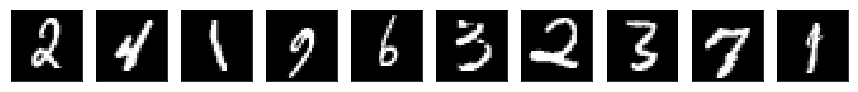

In [56]:

import ssl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


def load_all_mnist():
    ssl._create_default_https_context = ssl._create_unverified_context
    (train, _), (valid, _) = tf.keras.datasets.mnist.load_data()
    mnist = np.concatenate((train, valid), axis=0)
    return mnist


def sample_from(dataset, n_samp):
    n_total = dataset.shape[0]
    samp_indx = np.random.randint(
        low=0, high=n_total, size=n_samp)
    return np.take(dataset, indices=samp_indx, axis=0)
    

n_samples = 10
mnist_samples = sample_from(mnist, n_samples)

plt.clf()

unit = 15
figure_size = (unit,n_samples*unit)
fig, axes = plt.subplots(1, n_samples, figsize=figure_size)

for ax_indx in range(n_samples):
    axes[ax_indx].imshow(mnist_samples[ax_indx,:,:], cmap='gray')
    axes[ax_indx].set_xticks([])
    axes[ax_indx].set_yticks([])

plt.show()
